# 序列模型

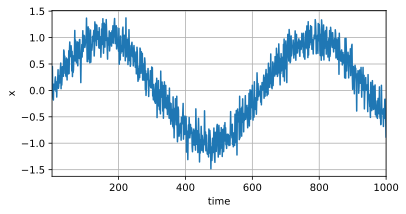

In [1]:
% matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [2]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [9]:
print(x)
print(features)
print(labels)

tensor([ 7.5502e-02,  4.5160e-01, -1.0306e-01, -1.6824e-01, -1.8176e-01,
         1.1773e-01,  1.0199e-01,  4.1432e-02,  1.4537e-02,  1.9532e-01,
         2.5460e-01,  1.2695e-01, -2.1095e-02,  1.6308e-01, -1.2544e-01,
         1.5877e-01,  5.4861e-02,  2.1066e-01,  3.9038e-01,  3.9596e-02,
         7.9052e-02,  2.6835e-01,  2.7937e-01,  1.4083e-01,  3.7056e-01,
         4.1460e-01,  5.1715e-01,  3.2409e-02,  4.3479e-01,  1.0193e-01,
         2.3039e-01,  4.5104e-01,  3.4972e-01,  2.9333e-01,  2.6680e-01,
         7.6498e-01,  7.3625e-01,  5.3409e-01,  6.4847e-01,  3.2332e-01,
         5.5313e-01,  2.8851e-01,  2.6272e-01,  6.1292e-01,  4.4919e-01,
         1.9849e-01,  5.8965e-01,  4.7679e-01,  5.2648e-01,  3.1248e-01,
         7.5033e-01,  3.1877e-01,  7.5226e-01,  9.1595e-01,  6.5852e-01,
         6.3889e-01,  6.6008e-01,  8.4501e-01,  7.4506e-01,  3.6804e-01,
         7.3769e-01,  2.6196e-01,  6.5908e-01,  3.3862e-01,  3.8396e-01,
         6.0319e-01,  5.7189e-01,  7.4637e-01,  1.1

In [5]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)  #均匀初始化权重


def get_net():
    net = nn.Sequential(
        nn.Linear(4, 10),
        nn.ReLU(),
        nn.Linear(10, 1)
    )
    net.apply(init_weights)
    return net


# 平方损失。注意i：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

In [6]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1},'
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')


net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1,loss: 0.054572
epoch 2,loss: 0.051836
epoch 3,loss: 0.050674
epoch 4,loss: 0.054077
epoch 5,loss: 0.052654


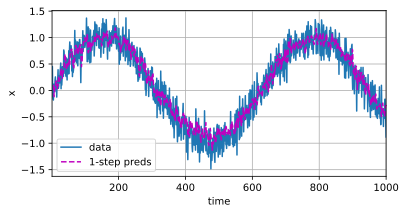

In [7]:
# 单步预测
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

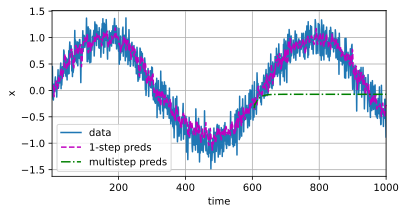

In [10]:
# 多步预测
multistep_preds = torch.zeros(T)
multistep_preds[:n_train + tau] = x[:n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1))
    )

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

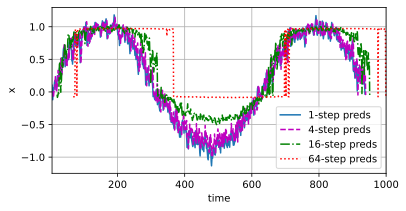

In [11]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, tau + i - 1].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))

# 文本数据预处理

解析文本的常见预处理步骤通常包括：
1. 将文本作为字符串加载到内存中。
2. 将字符串拆分为词元（如单词和字符）。
3. 建立一个词表，将拆分的词元映射到数字索引。
4. 将文本转换为数字索引序列，方便模型操作。

In [12]:
import collections
import re

首先，我们从H.G.Well的时光机器中加载文本。 这是一个相当小的语料库，只有30000多个单词，但足够我们小试牛刀， 而现实中的文档集合可能会包含数十亿个单词。 下面的函数将数据集读取到由多条文本行组成的列表中，其中每条文本行都是一个字符串。 为简单起见，我们在这里忽略了标点符号和字母大写。

In [13]:
#@save
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')


def read_time_machine():  #@save
    """将时间机器数据集加载到文本行的列表中"""
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in
            lines]  #将每一行字符串中非字母的字符替换为空白字符，删除首位空字符并将所有字母转换成小写


lines = read_time_machine()
print(f'# 文本行总数：{len(lines)}')
print(lines[0])
print(lines[10])

# 文本行总数：3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


In [14]:
# 词元化
def tokenize(lines, token='word'):  #@save
    """将文本拆分成单词或者字符词元"""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('错误：未知词元类型：' + token)


tokens = tokenize(lines)
for i in range(11):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


词元的类型是字符串，而模型需要的输入是数字，因此这种类型不方便模型使用。 现在，让我们构建一个字典，通常也叫做词表（vocabulary）， 用来将字符串类型的词元映射到从0开始的数字索引中。 我们先将训练集中的所有文档合并在一起，对它们的唯一词元进行统计， 得到的统计结果称之为语料（corpus）。 然后根据每个唯一词元的出现频率，为其分配一个数字索引。 很少出现的词元通常被移除，这可以降低复杂性。 另外，语料库中不存在或已删除的任何词元都将映射到一个特定的未知词元“<unk>”。 我们可以选择增加一个列表，用于保存那些被保留的词元， 例如：填充词元（“<pad>”）； 序列开始词元（“<bos>”）； 序列结束词元（“<eos>”）。

In [16]:
class Vocab:  #@save
    """文本词表"""

    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property  #将类的方法转换为属性调用
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs


def count_corpus(tokens):  #@save
    """统计词元的频率"""
    # isinstance:检查一个对象是否属于指定的类或类型
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)  #统计词频

**collections.Counter**

`collections.Counter`是Python标准库中的一个类，用于计数可哈希对象（例如列表、字符串等）的出现次数。

`Counter`类的作用是创建一个计数器对象，它可以接受一个可迭代对象作为输入，并统计其中每个元素的出现次数。它提供了一些方法和功能，使得对计数数据进行操作和查询变得非常方便。

下面是一个示例来演示`Counter`类的用法：

```python
from collections import Counter

# 创建一个计数器对象
word_list = ['apple', 'banana', 'apple', 'orange', 'banana', 'apple']
counter = Counter(word_list)

# 获取元素的计数
print(counter['apple'])    # 输出: 3，'apple'出现了3次
print(counter['banana'])   # 输出: 2，'banana'出现了2次
print(counter['orange'])   # 输出: 1，'orange'出现了1次

# 获取计数最多的元素
print(counter.most_common(2))  # 输出: [('apple', 3), ('banana', 2)]

# 更新计数器
new_word_list = ['apple', 'banana', 'apple', 'grape']
counter.update(new_word_list)
print(counter['apple'])    # 输出: 4，'apple'出现了4次

# 计数器运算
other_counter = Counter(['apple', 'cherry', 'banana'])
combined_counter = counter + other_counter
print(combined_counter['apple'])    # 输出: 5，'apple'出现了5次
```

通过使用`collections.Counter`类，我们可以轻松地统计元素的出现次数，并进行计数数据的操作，如获取计数最多的元素、更新计数器和进行计数器之间的运算等。这在很多数据处理和分析的场景中都非常有用。

**sorted(counter.items(), key=lambda x: x[1], reverse=True)**

`sorted(counter.items(), key=lambda x: x[1], reverse=True)` 是一个使用 Python 的内置函数 `sorted()` 进行排序的表达式。它对 `counter.items()` 的结果进行排序，按照计数值从大到小的顺序进行排列。

让我们逐步解释这个表达式的不同部分：

- `counter.items()`：`counter` 是一个 `Counter` 对象，它的 `items()` 方法返回一个包含键值对的迭代器，其中每个键值对由元素和计数值组成。

- `sorted(iterable, key, reverse)`：`sorted()` 函数用于对可迭代对象进行排序。它接受三个参数：
  - `iterable`：要排序的可迭代对象，这里传入的是 `counter.items()`，即键值对的迭代器。
  - `key`：用于指定排序的依据。在这里，使用 `lambda x: x[1]` 表达式作为键函数，表示按照每个键值对的第二个元素（即计数值）进行排序。
  - `reverse`：一个布尔值，用于指定排序顺序。如果设置为 `True`，则表示降序排列；如果设置为 `False`（默认值），则表示升序排列。

所以，`sorted(counter.items(), key=lambda x: x[1], reverse=True)` 将会对 `counter.items()` 的结果进行排序，按照计数值从大到小的顺序进行排列。返回的结果是一个排好序的列表，其中每个元素都是键值对，按照计数值降序排列。

这个表达式在获取计数器中最常出现的元素或按照计数值排序的需求中非常有用。

In [17]:
print(tokens[:50])
counter = count_corpus(tokens)
print(sorted(counter.items(), key=lambda x: x[1], reverse=True)[:20])

[['the', 'time', 'machine', 'by', 'h', 'g', 'wells'], [], [], [], [], ['i'], [], [], ['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him'], ['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and'], ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the'], ['fire', 'burned', 'brightly', 'and', 'the', 'soft', 'radiance', 'of', 'the', 'incandescent'], ['lights', 'in', 'the', 'lilies', 'of', 'silver', 'caught', 'the', 'bubbles', 'that', 'flashed', 'and'], ['passed', 'in', 'our', 'glasses', 'our', 'chairs', 'being', 'his', 'patents', 'embraced', 'and'], ['caressed', 'us', 'rather', 'than', 'submitted', 'to', 'be', 'sat', 'upon', 'and', 'there', 'was', 'that'], ['luxurious', 'after', 'dinner', 'atmosphere', 'when', 'thought', 'roams', 'gracefully'], ['free', 'of', 'the', 'trammels', 'of', 'precision', 'and', 'he', 'put', 'it', 'to', 'us', 'in', 'this'], ['way

In [26]:
vocab = Vocab(tokens)
print(type(vocab.token_freqs))
print(type(vocab.idx_to_token))
print(type(vocab.token_to_idx))
print(vocab.unk)
print(vocab)

<class 'list'>
<class 'list'>
<class 'dict'>
0


In [25]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


In [27]:
for i in [0, 10]:
    print('文本:', tokens[i])
    print('索引:', vocab[tokens[i]])

文本: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
索引: [1, 19, 50, 40, 2183, 2184, 400]
文本: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
索引: [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


**vocab = Vocab(tokens)**

`vocab = Vocab(tokens)` 是用给定的 `tokens` 创建一个名为 `vocab` 的词汇表对象。

`vocab[tokens[i]]` 是通过索引操作访问词汇表 `vocab` 中索引为 `tokens[i]` 的词元。

这种写法属于 Python 中的特殊方法（special method）或者说魔术方法（magic method）的一种，即 `__getitem__()` 方法。在 Python 中，通过在对象上使用方括号 `[]` 运算符，可以调用 `__getitem__()` 方法。

在这种情况下，`vocab[tokens[i]]` 实际上是调用了词汇表对象 `vocab` 的 `__getitem__()` 方法，传入索引值 `tokens[i]`，返回对应的词元。

这种写法允许我们通过索引操作从词汇表中获取词元，使得词汇表对象可以像列表或字典一样进行索引访问，提供了更加方便和直观的方式来操作词汇表中的元素。

将所有功能打包到load_corpus_time_machine函数中， 该函数返回corpus（词元索引列表）和vocab（时光机器语料库的词表）。 我们在这里所做的改变是：
1. 为了简化后面章节中的训练，我们使用字符（而不是单词）实现文本词元化；
2. 时光机器数据集中的每个文本行不一定是一个句子或一个段落，还可能是一个单词，因此返回的corpus仅处理为单个列表，而不是使用多词元列表构成的一个列表。


In [28]:
def load_corpus_time_machine(max_tokens=-1):  #@save
    """返回时光机器数据集的词元索引列表和词表"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # 因为时光机器数据集中每个文本行不一定是一个句子或一个段落，所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab


corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(170580, 28)

In [34]:
print(vocab.token_freqs)
print(vocab.idx_to_token)
print(vocab.token_to_idx)
print(vocab.unk)
print(vocab)

[(' ', 29927), ('e', 17838), ('t', 13515), ('a', 11704), ('i', 10138), ('n', 9917), ('o', 9758), ('s', 8486), ('h', 8257), ('r', 7674), ('d', 6337), ('l', 6146), ('m', 4043), ('u', 3805), ('c', 3424), ('f', 3354), ('w', 3225), ('g', 3075), ('y', 2679), ('p', 2427), ('b', 1897), ('v', 1295), ('k', 1087), ('x', 236), ('z', 144), ('j', 97), ('q', 95)]
['<unk>', ' ', 'e', 't', 'a', 'i', 'n', 'o', 's', 'h', 'r', 'd', 'l', 'm', 'u', 'c', 'f', 'w', 'g', 'y', 'p', 'b', 'v', 'k', 'x', 'z', 'j', 'q']
{'<unk>': 0, ' ': 1, 'e': 2, 't': 3, 'a': 4, 'i': 5, 'n': 6, 'o': 7, 's': 8, 'h': 9, 'r': 10, 'd': 11, 'l': 12, 'm': 13, 'u': 14, 'c': 15, 'f': 16, 'w': 17, 'g': 18, 'y': 19, 'p': 20, 'b': 21, 'v': 22, 'k': 23, 'x': 24, 'z': 25, 'j': 26, 'q': 27}
0


# 语言模型和数据集

In [35]:
import random

# 统计单个单词的词频
tokens = d2l.tokenize(d2l.read_time_machine())
# 因为每个文本行不一定是一个句子或一个段落，因此我们把所有文本行拼接到一起
corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

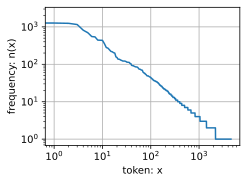

In [36]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
         xscale='log', yscale='log')

In [37]:
# 统计2个单词组成的词组的词频
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = d2l.Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [38]:
# 统计3个单词组成的词组的词频
trigram_tokens = [triple for triple in zip(corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = d2l.Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

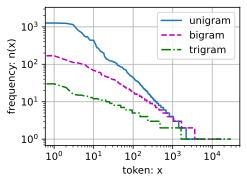

In [39]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

当处理长序列数据时，由于序列长度较长，一次性将整个序列加载到内存中可能会导致内存不足的问题。因此，常常使用随机采样和顺序分区策略来读取长序列数据，以便有效地处理和训练模型。

1. 随机采样（Random Sampling）：
   - 在随机采样策略中，数据集被随机划分为多个固定长度的小序列，然后从中随机选择一个小序列进行训练。
   - 这种策略确保每个小序列被等概率地选中，从而避免了对数据集中的某些部分过度训练或忽略。
   - 在每个训练迭代中，随机选择一个小序列，然后使用它进行模型的前向传播和反向传播更新参数。
   - 随机采样可以通过将数据集分成多个小文件或块，并从中随机选择进行采样。

2. 顺序分区（Sequential Partitioning）：
   - 在顺序分区策略中，数据集被分成多个固定长度的小序列，并按顺序依次训练这些小序列。
   - 首先，将数据集分成多个连续的小序列，然后按顺序依次选择这些小序列进行训练。
   - 在每个训练迭代中，选择一个小序列，然后使用它进行模型的前向传播和反向传播更新参数。
   - 顺序分区保证了整个数据集的完整性，同时可以通过限制每个小序列的长度来减少内存的占用。

随机采样和顺序分区策略都是为了处理长序列数据时的内存限制问题。随机采样将数据集划分为多个小序列并随机选择进行训练，以保证每个小序列的平等性；顺序分区将数据集按顺序分成小序列并按顺序训练，以保证整个数据集的完整性。选择使用哪种策略取决于具体的需求和资源限制。

In [40]:
# 随机采样
def seq_data_iter_random(corpus, batch_size, num_steps):
    """使用随机抽样生成一个小批量子序列"""
    # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减去1，是因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为num_steps的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中，来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)

    def data(pos):
        # 返回从pos位置开始的长度为num_steps的序列
        return corpus[pos:pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，initial_indices包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i:i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

In [41]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)


X:  tensor([[12, 13, 14, 15, 16],
        [27, 28, 29, 30, 31]]) 
Y: tensor([[13, 14, 15, 16, 17],
        [28, 29, 30, 31, 32]])
X:  tensor([[ 2,  3,  4,  5,  6],
        [ 7,  8,  9, 10, 11]]) 
Y: tensor([[ 3,  4,  5,  6,  7],
        [ 8,  9, 10, 11, 12]])
X:  tensor([[17, 18, 19, 20, 21],
        [22, 23, 24, 25, 26]]) 
Y: tensor([[18, 19, 20, 21, 22],
        [23, 24, 25, 26, 27]])


In [42]:
# 顺序分区
def seq_data_iter_sequential(corpus, batch_size, num_steps):  #@save
    """使用顺序分区生成一个小批量子序列"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset:offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1:offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i:i + num_steps]
        Y = Ys[:, i:i + num_steps]
        yield X, Y

In [43]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 0,  1,  2,  3,  4],
        [17, 18, 19, 20, 21]]) 
Y: tensor([[ 1,  2,  3,  4,  5],
        [18, 19, 20, 21, 22]])
X:  tensor([[ 5,  6,  7,  8,  9],
        [22, 23, 24, 25, 26]]) 
Y: tensor([[ 6,  7,  8,  9, 10],
        [23, 24, 25, 26, 27]])
X:  tensor([[10, 11, 12, 13, 14],
        [27, 28, 29, 30, 31]]) 
Y: tensor([[11, 12, 13, 14, 15],
        [28, 29, 30, 31, 32]])


In [44]:
#将上面的两个采样函数包装到一个类中， 以便稍后可以将其用作数据迭代器
class SeqDataLoader:  #@save
    """加载序列数据的迭代器"""

    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [45]:
def load_data_time_machine(batch_size, num_steps,  #@save
                           use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

# 机器翻译

In [47]:
import os

#@save
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip',
                           '94646ad1522d915e7b0f9296181140edcf86a4f5')


#@save
def read_data_nmt():
    """载入“英语－法语”数据集"""
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r',
              encoding='utf-8') as f:
        return f.read()


raw_text = read_data_nmt()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



In [48]:
#@save
def preprocess_nmt(text):
    """预处理 英语-法语 数据集"""

    def no_space(char, prev_char):
        return char in set(',.?!') and prev_char != ' '

    # 使用空格替换不间断空格，使用小写字母替换大写字母
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # 在单词和标点符号之间插入空格
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char for i, char in enumerate(text)]
    return ''.join(out)


text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


In [49]:
#@save
def tokenize_nmt(text, num_examples=None):
    """词元化 英语-法语 数据集"""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target


source, target = tokenize_nmt(text)
source[:6], target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

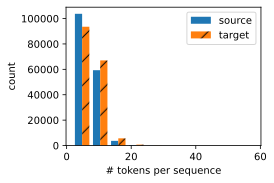

In [50]:
#@save
def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):
    """绘制列表长度对的直方图"""
    d2l.set_figsize()
    _, _, patches = d2l.plt.hist(
        [[len(l) for l in xlist], [len(l) for l in ylist]])
    d2l.plt.xlabel(xlabel)
    d2l.plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch('/')
    d2l.plt.legend(legend)


show_list_len_pair_hist(['source', 'target'], '# tokens per sequence',
                        'count', source, target);

**词表**

由于机器翻译数据集由语言对组成， 因此我们可以分别为源语言和目标语言构建两个词表。 使用单词级词元化时，词表大小将明显大于使用字符级词元化时的词表大小。 为了缓解这一问题，这里我们将出现次数少于2次的低频率词元 视为相同的未知（“<unk>”）词元。 除此之外，我们还指定了额外的特定词元， 例如在小批量时用于将序列填充到相同长度的填充词元（“<pad>”）， 以及序列的开始词元（“<bos>”）和结束词元（“<eos>”）。 这些特殊词元在自然语言处理任务中比较常用。

In [51]:
src_vocab = d2l.Vocab(source, min_freq=2,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)


10012

语言模型中的序列样本都有一个固定的长度， 无论这个样本是一个句子的一部分还是跨越了多个句子的一个片断。 这个固定长度是由 8.3节中的 num_steps（时间步数或词元数量）参数指定的。 在机器翻译中，每个样本都是由源和目标组成的文本序列对， 其中的每个文本序列可能具有不同的长度。

为了提高计算效率，我们仍然可以通过截断（truncation）和 填充（padding）方式实现一次只处理一个小批量的文本序列。 假设同一个小批量中的每个序列都应该具有相同的长度num_steps， 那么如果文本序列的词元数目少于num_steps时， 我们将继续在其末尾添加特定的“<pad>”词元， 直到其长度达到num_steps； 反之，我们将截断文本序列时，只取其前num_steps 个词元， 并且丢弃剩余的词元。这样，每个文本序列将具有相同的长度， 以便以相同形状的小批量进行加载。

如前所述，下面的truncate_pad函数将截断或填充文本序列。

In [52]:
#@save
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    if len(line) > num_steps:
        return line[:num_steps]
    return line + [padding_token] * (num_steps - len(line))  # 填充


truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

现在我们定义一个函数，可以将文本序列 转换成小批量数据集用于训练。 我们将特定的“<eos>”词元添加到所有序列的末尾， 用于表示序列的结束。 当模型通过一个词元接一个词元地生成序列进行预测时， 生成的“<eos>”词元说明完成了序列输出工作。 此外，我们还记录了每个文本序列的长度， 统计长度时排除了填充词元， 在稍后将要介绍的一些模型会需要这个长度信息。

In [53]:
#@save
def build_array_nmt(lines, vocab, num_steps):
    """将机器翻译的文本序列转换成小批量"""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([truncate_pad(l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len

In [54]:
#@save
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """返回翻译数据集的迭代器和词表"""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

In [55]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', X.type(torch.int32))
    print('X的有效长度:', X_valid_len)
    print('Y:', Y.type(torch.int32))
    print('Y的有效长度:', Y_valid_len)
    break

X: tensor([[ 24,  10,   4,   3,   1,   1,   1,   1],
        [ 14, 172,   4,   3,   1,   1,   1,   1]], dtype=torch.int32)
X的有效长度: tensor([4, 4])
Y: tensor([[13,  8,  4,  3,  1,  1,  1,  1],
        [64,  5,  3,  1,  1,  1,  1,  1]], dtype=torch.int32)
Y的有效长度: tensor([4, 3])
